In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import math
%matplotlib inline

To visualize a convolutional neural network, we'll draw a graph in code. The main idea here is that not every node is connected. A convolutional neural network is locally connected, not densely connected.

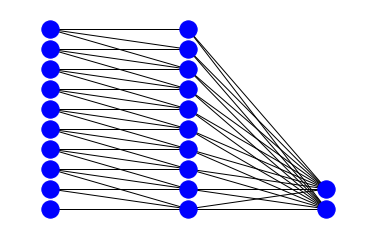

In [2]:
convolve = nx.Graph()
inputs = {i: (0, i) for i in range(0, 10)}
activations = {i+100: (1, i) for i in range(0, 10)}
outputs= {i+1000: (2, i) for i in range(0, 2)}
all = {**inputs, **activations, **outputs}
#and now -- convolutionally connected

def window(items, kernel):
    windows = []
    at = 0
    while at < len(items) + kernel:
        windows.append(items[at:at+kernel])
        at = at + 1
    return windows

for i, w in enumerate(window(list(inputs.keys()), 3)):
    for input in w:
        convolve.add_edge(input, i+100)
for activation in activations:
    for output in outputs:
        convolve.add_edge(activation, output)
nx.draw_networkx_nodes(convolve, all, nodelist=all.keys(), node_color='b')
nx.draw_networkx_edges(convolve, all)
plt.axis('off')
pass


And now in two dimensions, we'll take a 3x3 patch and show how it is connected.

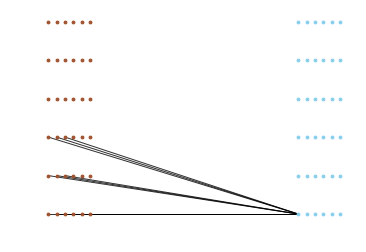

In [3]:
import itertools
import matplotlib.pyplot as plt
size = 6


mnist = nx.Graph()
pixels = {i: (x, y) for i, (x, y) in enumerate(itertools.product(range(0, size), range(0, size)))}
pixel_lookup = {position: i for i, position in pixels.items()}
activations = {i+1000: (x+30, y) for i, (x, y) in enumerate(itertools.product(range(0, size), range(0, size)))}
all = {**pixels, **activations}
for x in range(0, 3):
    for y in range(0, 3):
        pixel = pixel_lookup[(x, y)]
        mnist.add_edge(pixel, 1000)

nx.draw_networkx_nodes(mnist, pixels, nodelist=pixels.keys(), node_color='sienna', node_size=8)
nx.draw_networkx_nodes(mnist, activations, nodelist=activations.keys(), node_color='skyblue', node_size=8)
nx.draw_networkx_edges(mnist, all, alpha=0.8)
plt.axis('off')
pass

And now -- pooling. Pooling combines numerical values looking for the strongest / maximum signal. Demonstrating this - we'll learn a new trick, using Keras just to do math.

In [4]:
import keras
from keras.datasets import mnist
from keras.layers import Input, Dense, Dropout, Flatten, MaxPooling2D, MaxPooling1D, Conv2D
from keras.models import Model, Sequential
import numpy as np

Using TensorFlow backend.


In [5]:
sample = np.array([
    [1, 1, 4, 1],
    [1, 1, 1, 1],
    [2, 1, 1, 5],
    [1, 3, 1, 1],
])

pool = Sequential()
pool.add(MaxPooling1D(pool_size=(4), input_shape=(4, 4)))
pooled = np.squeeze(pool.predict_on_batch(np.array([sample])))
print(pooled)

[ 2.  3.  4.  5.]


Pooling in two dimensions is set up a bit different. There is a 'third dimension' -- the channel. Typically this is used for color images such as Red/Green/Blue pixel channels, but we'll limit our example to one channel of Black/White.

Numpy expand_dims will tack on an additional 'dimension' with only 1 possible value in order to fit Keras assumptions.

In [6]:

pool2 = Sequential()
pool2.add(MaxPooling2D(pool_size=(2), input_shape=(4, 4, 1)))
pooled2 = np.squeeze(pool2.predict_on_batch(np.array([np.expand_dims(sample, -1)])))

for row in pooled2:
    print(row)
    

[ 1.  4.]
[ 3.  5.]


And now -- knowing about Convolution and Pooling, let's use these layers and do some machine learning.
First -- the MNIST digits.

In [7]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()
x_train = np.expand_dims(x_train / np.max(x_train), -1)
x_test = np.expand_dims(x_test / np.max(x_test), -1)
y_train = keras.utils.to_categorical(y_train, 10)
y_test = keras.utils.to_categorical(y_test, 10)

10731520/11490434 [===========================>..] - ETA: 0s

And now, using the Keras, build a model that has convolution, pooling, dropout and a final softmax classification.


One thing to note here is Flatten. Because our images are two dimensional *x,y* pairs, and our output is one dimension -- a class 0-9, Flatten is needed to reduce the dimensions.


In [8]:
input_shape = x_train[0].shape
num_classes = 10
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 26, 26, 32)        320       
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 64)        18496     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 12, 12, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 12, 12, 64)        0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 9216)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 128)               1179776   
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
__________

With the model assembled, we compile it, which prepares the model for execution with a solver. And fit to the training data. This is similar to what we did with the Classical/Dense network -- in fact identical

In [10]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(x_train, y_train,
                    batch_size=64,
                    epochs=8,
                    verbose=1,
                    validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/8
60000/60000 [==============================] - 108s - loss: 0.1564 - acc: 0.9533 - val_loss: 0.0485 - val_acc: 0.9834
Epoch 2/8
60000/60000 [==============================] - 100s - loss: 0.0755 - acc: 0.9769 - val_loss: 0.0378 - val_acc: 0.9869
Epoch 3/8
60000/60000 [==============================] - 56s - loss: 0.0565 - acc: 0.9831 - val_loss: 0.0319 - val_acc: 0.9894
Epoch 4/8
60000/60000 [==============================] - 56s - loss: 0.0455 - acc: 0.9861 - val_loss: 0.0303 - val_acc: 0.9904
Epoch 5/8
60000/60000 [==============================] - 56s - loss: 0.0415 - acc: 0.9865 - val_loss: 0.0283 - val_acc: 0.9906
Epoch 6/8
60000/60000 [==============================] - 56s - loss: 0.0358 - acc: 0.9883 - val_loss: 0.0276 - val_acc: 0.9921
Epoch 7/8
60000/60000 [==============================] - 56s - loss: 0.0315 - acc: 0.9897 - val_loss: 0.0273 - val_acc: 0.9913
Epoch 8/8
60000/60000 [==============================] - 56